In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.layers import AveragePooling2D, Dense, Flatten, Dropout
from keras.models import Model

Using TensorFlow backend.


In [2]:
normal_path = "../IT workshop/COVID-19_Radiography_Dataset/Normal/images"
viral_path = "../IT workshop/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
covid_path = "../IT workshop/COVID-19_Radiography_Dataset/COVID/images"

In [3]:
filenames = os.listdir(normal_path) + os.listdir(viral_path) + os.listdir(covid_path) 

In [4]:
# 0 -> Normal
# 1 -> Viral Pneumonia
# 2 -> COVID-19

categories = []
paths = []
for filename in filenames:
    if "Normal" in filename:
        categories.append('normal')
        paths.append(normal_path + '/' + filename)
    if "Viral Pneumonia" in filename:
        categories.append('viral pneumonia')
        paths.append(viral_path + '/' + filename)
    if "COVID" in filename:
        categories.append('covid')
        paths.append(covid_path + '/' + filename)

In [5]:
df = pd.DataFrame({
    'File Path' : paths,
    'Category' : categories
})

In [6]:
df[df['Category'] == 'viral pneumonia']

,File Path,Category
10192,../IT workshop/COVID-19_Radiography_Dataset/Vi...,viral pneumonia
10193,../IT workshop/COVID-19_Radiography_Dataset/Vi...,viral pneumonia
10194,../IT workshop/COVID-19_Radiography_Dataset/Vi...,viral pneumonia
10195,../IT workshop/COVID-19_Radiography_Dataset/Vi...,viral pneumonia
10196,../IT workshop/COVID-19_Radiography_Dataset/Vi...,viral pneumonia
...,...,...
11532,../IT workshop/COVID-19_Radiography_Dataset/Vi...,viral pneumonia
11533,../IT workshop/COVID-19_Radiography_Dataset/Vi...,viral pneumonia
11534,../IT workshop/COVID-19_Radiography_Dataset/Vi...,viral pneumonia
11535,../IT workshop/COVID-19_Radiography_Dataset/Vi...,viral pneumonia


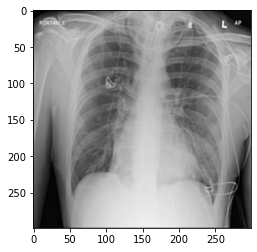

In [7]:
img = cv2.imread(df['File Path'][2000])
plt.imshow(img)

In [8]:
#Splitting into training and testing data
train_data , test_valid_data = train_test_split(df, test_size=0.25, random_state = 42, 
                                                shuffle=True, stratify=df['Category'])

In [9]:
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [10]:
#Splitting testing data into validation and testing data
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['Category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

In [11]:
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [12]:
train_gen = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='File Path',
    y_col='Category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 11364 validated image filenames belonging to 3 classes.


In [13]:
valid_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

valid_gen = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='File Path',
    y_col='Category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)


Found 1895 validated image filenames belonging to 3 classes.


In [14]:
base_model = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

In [15]:
# Customisations to VGG16:
# Adding Pooling and Flatten layers to the model
# Adding 1 hidden layer where we chose the activation function as Rectified Linear Unit
# Adding a Dropout layer to prevent overfitting of model
# Finaly using a softmax in our output layer

In [16]:
for layer in base_model.layers:
    layer.trainable = False

head_model = base_model.output
head_model = AveragePooling2D()(head_model)
head_model = Flatten()(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(3, activation='softmax')(head_model)

model = Model(inputs=base_model.input, outputs=head_model)

In [17]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 5
model.fit(train_gen, epochs=epochs, validation_data=valid_gen, verbose=1)

Epoch 1/5
116/356 [========>.....................] - ETA: 16:46:56 - loss: 0.5814 - accuracy: 0.7500